This is a slight modification of the word2vec tensorflow tutorial. This is commented heavily so that the significance of each and every line is properly 
comprehended by the user.

In [22]:
import tensorflow as tf
import nltk
import urllib
import collections
import numpy as np
import math
from six.moves import xrange
import os
from tempfile import gettempdir
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Defining a function to open the text file and create a list of words. The total number of unique words are also printed.

In [2]:
def read_data(filename = 'text8'):
    text_file = open('data/'+str(filename),'r')
    words = text_file.read().split()
    return words

words = read_data()
print(len(set(words))) # Prints the total number of unique words

count = collections.Counter(words) # To get the count of each word and visualize the top 10 most frequent words
count.most_common()[:10]

253854


[('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430),
 ('two', 192644)]

Defining a function to create data,count, word_dictionary and reversed dictionary. Rare words (words 
outside our definded vocabulary) are replaced with the 'UNK' token. 'word_dictionary' is a dictionary which maps the actual word to it's integer representation. 'count' will be a list, each element being the word and its number of occurrence.(First element of count is 'UNK' and the count of all words not present in the vocabulary that we define). 'data' is a list which is obtained by substituting each 
word in 'words' with its integer representation (the input data generated from read_data). So basically, we convert words to integer representation. 'reversed_dictionary' is the reverse mapping of 'word_dictionary' (from integer labels to words)

In [3]:
vocabulary_size = 50000 # Defining how many words to consider in our vocabulary

def create_train_data(words,vocab_size):
    # initially setting the first element of 'count' as the 'UNK' token (for rare words) and its occurrence as -1
    # Its occurrence will be changed later
    count = [['UNK',-1]] 
    # Populating the count list with the rest of the words as per vocab_size. (We take the most common words)
    count.extend(collections.Counter(words).most_common(vocab_size-1)) # 1 less as the first element is 'UNK'
    
    # Now creating 'word_dictionary' which maps words to integer labels.
    word_dictionary = dict()
    for word,occurence in count:
        word_dictionary[word] = len(word_dictionary) # So it assigns an integer label as the dictionary fills up.
    
    # Now creating 'data' which converts words list to a list of its integer representations
    # We only take words defined in the word_dictionary as we have a fixed vocabulary(vocab_size)
    # All other words are 'UNK'
    data = list()
    unk_count = 0
    for word in words:
        if word in word_dictionary: 
            index = word_dictionary[word]
        else:
            index = 0 # Word not in dictionary, so label is 0 which is 'UNK'
            unk_count += 1 # To get the unknown count at the end to update the first element of 'count'
        data.append(index)
    
    # updating the first element of count. i.e, updating the count of 'UNK'
    count[0][1] = unk_count 
    # To get the reverse mapping
    reversed_dictionary = dict(zip(word_dictionary.values(),word_dictionary.keys())) 
    return data, count, word_dictionary, reversed_dictionary

# Print and check the visualize these objects
data, count, word_dictionary, reversed_dictionary = create_train_data(words,vocabulary_size)

Now we have our data prepared. Checking the first 10 elements of data and count.

In [6]:
data[:10], count[:10]

([5244, 3081, 12, 6, 195, 2, 3137, 46, 59, 156],
 [['UNK', 418391],
  ('the', 1061396),
  ('of', 593677),
  ('and', 416629),
  ('one', 411764),
  ('in', 372201),
  ('a', 325873),
  ('to', 316376),
  ('zero', 264975),
  ('nine', 250430)])

In [5]:
data_index = 0 
# This is a global variable and is declared as global in the function below to keep track of the index of data so as to generate the next batch.

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  if data_index + span > len(data):
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  #print("Buffer")
  #print(buffer)
  data_index += span
  for i in range(batch_size // num_skips): 
      # basically i acts as a counter for taking the target word. Batch size is 8. 2 context words are taken,
      # 1 on the left and 1 on the right. So 8/2 = 4. Hence we get 4 target words. Uncomment the print statements to visualize. 
      
    context_words = [w for w in range(span) if w != skip_window]
    random.shuffle(context_words)
    words_to_use = collections.deque(context_words)
    #print("Words to use")
    #print(words_to_use)
    for j in range(num_skips):
      #print("prev Batch")
      #print(batch)
      batch[i * num_skips + j] = buffer[skip_window]  # Target Word. 
      # i*num_skips + j basically acts as a counter for the indices of the batch, just like writing numbers like 11 as (1*10 + 1)
      context_word = words_to_use.pop() 
      # Grab the index of a context word from words_to_use and then pop it from the deque. So now this popped index is stored in context_word
      labels[i * num_skips + j, 0] = buffer[context_word] # Now use this popped word  as the label. 
      # (We are predicting context words from center word)
      #print("Batch")
      #print(batch)
      #print("Labels")
      #print(labels)
    if data_index == len(data):
      buffer[:] = data[:span]
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

Visualizing a batch of 8

In [9]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reversed_dictionary[batch[i]],
        '->', labels[i, 0], reversed_dictionary[labels[i, 0]])

195 term -> 2 of
195 term -> 6 a
2 of -> 3137 abuse
2 of -> 195 term
3137 abuse -> 2 of
3137 abuse -> 46 first
46 first -> 3137 abuse
46 first -> 59 used


Bulding the skip-gram model and the tensorflow graph

In [10]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label. Use 2 when skip_window = 1 (So it generates 2 pairs for one word)

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False) # generates a random sized subset in the range (o, valid_window)
num_sampled = 64    # Number of negative examples to sample.

In [13]:
vocabulary_size = 50000

graph = tf.Graph()
with graph.as_default():
     # setting placeholders and constants for input data, labels and validation dataset
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
     
    # defining a variable for the word embeddings and initializing them with numbers between -1 and 1.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size],-1.0,1.0)) 
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)  
    # This picks up all the tensors in the embeddings according to the ids obtained from train_inputs
    # This can be taken as the output of a multiplication happening at the first hidden layer of the neural net. (just for understanding)
    # Basically like a multiplication in which input tensor is a one hot of dim[batch_size x embedding_size). # ( the hot element corresponding 
    # to the ids of words given by inputs) So basically embeddings is like the weights of this first layer.
    # But internally during backprop, this layer is like a dictionary which reverse maps so that it sends 
    # out the gradients only to those rows of  embeddings that were used in that particular batch. Hence it will be much more faster than
    # representing this operation with a typical neural network layer with the embeddings as its weights.
    # Remember that train_inputs is just a tensor of a set of integers governed by batch_size which are 
    # the integer representations of the words in data 
     
    # Constructing weights and biases for NCE Loss
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev = 1.0/math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    # in NCE loss, 'inputs' actually represent the input to the nce_loss and not the input of the neural net.
    # The input to the nce_loss will be the output of the previous layer. The previous layer is the embedding_lookup layer
    #
    loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))
    
    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
          normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
          valid_embeddings, normalized_embeddings, transpose_b=True)
    
    # Add variable initializer.
    init = tf.global_variables_initializer()

A high level explanation for the optimization of nce loss obtained from stackoverflow (given by curator23) : 
"The embeddings Tensor is your final output matrix. It maps words to vectors. Use this in your word prediction graph.
The input matrix is a batch of centre-word : context-word pairs (train_input and train_label respectively) generated from the training text.
While the exact workings of the nce_loss op are not yet know to me, the basic idea is that it uses a single layer network (parameters nce_weights and nce_biases) to map an input vector (selected from embeddings using the embed op) to an output word, and then compares the output to the training label (an adjacent word in the training text) and also to a random sub-sample (num_sampled) of all other words in the vocab, and then modifies the input vector (stored in embeddings) and the network parameters to minimise the error."

Training the skip-gram model

In [14]:
# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reversed_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reversed_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized


Average loss at step  0 :  262.546264648
Nearest to or: fool, pinball, freaks, dcsd, clairvoyance, submitting, crony, hook,
Nearest to d: natchez, anarchy, awhile, carter, dangerously, saint, aires, icons,
Nearest to time: modified, rejuvenated, advance, lande, ethel, vampyre, boles, barren,
Nearest to use: palma, cryptozoology, valves, mcleod, indicate, concludes, cavitation, myra,
Nearest to as: whaling, franken, mindaugas, byrds, conciliatory, ruddy, unprepared, rout,
Nearest to some: areal, satisfied, levite, focussing, got, spock, pieter, leisurely,
Nearest to see: feared, fabien, dignitaries, pcc, af, abandonment, lees, treat,
Nearest to nine: watt, photovoltaic, observers, incorporating, triangular, polymorphism, peres, coupland,
Nearest to states: christensen, nasty, pandora, enhances, catalunya, solute, segmentation, keenly,
Nearest to two: dune, alger, joss, regiments, eleanor, resistivity, immanuel, garbage,
Nearest to that: wheels, mediating, pledges, sabres, repulsion, kar

Average loss at step  2000 :  114.209281477


Average loss at step  4000 :  51.7368319688


Average loss at step  6000 :  33.3482650504


Average loss at step  8000 :  23.6968632545


Average loss at step  10000 :  17.8651894919
Nearest to or: and, gland, boards, archie, UNK, phi, within, the,
Nearest to d: aires, anarchy, saint, impossibility, proceeded, kurtz, autism, cars,
Nearest to time: gland, advance, modified, career, somalia, gb, refrigerator, antimatter,
Nearest to use: phi, indicate, gland, altenberg, mosque, valves, cdc, king,
Nearest to as: in, and, few, is, bckgr, phi, was, veterans,
Nearest to some: archie, namibia, believed, got, dakar, same, nilo, pieter,
Nearest to see: feared, abandonment, marcus, treat, harvard, comic, archie, UNK,
Nearest to nine: zero, mathbf, eight, gland, six, one, coke, austin,
Nearest to states: phi, gland, surveyed, ng, center, hints, chess, chordata,
Nearest to two: one, coke, nine, phi, mathbf, archie, zero, ada,
Nearest to that: wheels, phi, unorganized, mathbf, gland, treated, accusations, judgement,
Nearest to who: hegel, mpla, and, austin, tunnel, azerbaijan, compound, cultures,
Nearest to his: the, their, gland, att

Average loss at step  12000 :  13.9755555441


Average loss at step  14000 :  11.5936017632


Average loss at step  16000 :  9.85133024311


Average loss at step  18000 :  8.57397077698


Average loss at step  20000 :  8.13583571553
Nearest to or: and, gland, UNK, circ, two, zero, with, of,
Nearest to d: b, one, impossibility, anarchy, aires, saint, subgroups, proceeded,
Nearest to time: gland, career, advance, modified, dormitory, barren, cash, agouti,
Nearest to use: indicate, phi, gland, valves, palma, apologia, dasyprocta, altenberg,
Nearest to as: in, and, is, was, for, few, veterans, bckgr,
Nearest to some: the, agouti, tiberius, albuquerque, isu, prohibit, dakar, many,
Nearest to see: and, feared, marcus, abandonment, harvard, treat, declare, sloane,
Nearest to nine: eight, six, five, seven, zero, four, circ, agouti,
Nearest to states: phi, gland, ng, hints, surveyed, chordata, agouti, nasty,
Nearest to two: one, three, six, eight, nine, zero, four, five,
Nearest to that: which, but, wheels, judgement, unorganized, gland, phi, sunderland,
Nearest to who: and, he, mpla, hegel, but, compound, romantic, tunnel,
Nearest to his: the, their, her, kits, s, its, antoninu

Average loss at step  22000 :  7.11653461981


Average loss at step  24000 :  6.89953189027


Average loss at step  26000 :  6.67421933174


Average loss at step  28000 :  6.32994098282


Average loss at step  30000 :  5.89309946418
Nearest to or: and, gland, circ, with, agouti, archie, nine, three,
Nearest to d: b, anarchy, impossibility, aires, shorts, one, and, subgroups,
Nearest to time: gland, modified, career, advance, dormitory, barren, cash, three,
Nearest to use: indicate, palma, valves, gland, phi, altenberg, apologia, dasyprocta,
Nearest to as: and, by, in, is, for, few, circ, was,
Nearest to some: many, the, prohibit, agouti, tiberius, dakar, bulldog, isu,
Nearest to see: and, marcus, harvard, treat, abandonment, feared, declare, hbox,
Nearest to nine: eight, six, seven, five, four, zero, three, circ,
Nearest to states: phi, gland, ng, hints, surveyed, christensen, nasty, chordata,
Nearest to two: three, four, six, five, one, eight, zero, circ,
Nearest to that: which, this, but, unorganized, gland, it, wheels, mathbf,
Nearest to who: and, he, mpla, but, they, also, which, hegel,
Nearest to his: their, the, her, its, s, providence, kits, antoninus,
Nearest to

Average loss at step  32000 :  5.95006074452


Average loss at step  34000 :  5.70196425128


Average loss at step  36000 :  5.76208182502


Average loss at step  38000 :  5.52583925509


Average loss at step  40000 :  5.24976281738
Nearest to or: and, zero, circ, gland, agouti, dasyprocta, with, archie,
Nearest to d: b, anarchy, impossibility, aires, zero, shorts, subgroups, saint,
Nearest to time: gland, modified, three, career, dormitory, advance, four, barren,
Nearest to use: indicate, valves, gland, akita, palma, phi, lobster, altenberg,
Nearest to as: and, in, by, is, circ, praxis, zero, ize,
Nearest to some: many, the, agouti, each, prohibit, archie, tiberius, bulldog,
Nearest to see: treat, declare, and, marcus, harvard, sloane, agouti, albury,
Nearest to nine: eight, six, seven, zero, five, four, three, agouti,
Nearest to states: phi, gland, akita, nasty, pandora, surveyed, christensen, hints,
Nearest to two: three, one, four, five, six, eight, zero, seven,
Nearest to that: which, this, it, but, gland, alphorn, mathbf, sunderland,
Nearest to who: he, and, which, also, they, mpla, but, saeed,
Nearest to his: their, her, the, its, providence, kits, s, agouti,
Nea

Average loss at step  42000 :  5.37822328413


Average loss at step  44000 :  5.22777500772


Average loss at step  46000 :  5.247514853


Average loss at step  48000 :  5.23882020879


Average loss at step  50000 :  5.00451873398
Nearest to or: and, circ, gland, four, eight, agouti, seven, two,
Nearest to d: b, impossibility, anarchy, four, aires, subgroups, amalthea, dangerously,
Nearest to time: gland, four, modified, three, dormitory, advance, career, agouti,
Nearest to use: palma, valves, gland, indicate, akita, lobster, phi, dasyprocta,
Nearest to as: by, four, five, agouti, circ, schoolchildren, is, praxis,
Nearest to some: many, these, several, the, agouti, each, bulldog, prohibit,
Nearest to see: declare, and, treat, marcus, albury, marek, harvard, agouti,
Nearest to nine: eight, six, seven, zero, three, five, four, agouti,
Nearest to states: pandora, nasty, phi, akita, gland, segmentation, hints, christensen,
Nearest to two: three, four, one, six, five, eight, circ, seven,
Nearest to that: which, this, but, sunderland, shtml, it, however, mathbf,
Nearest to who: and, he, which, also, they, mpla, saeed, there,
Nearest to his: their, her, its, the, s, providen

Average loss at step  52000 :  5.07307770491


Average loss at step  54000 :  5.17410199237


Average loss at step  56000 :  5.0292929312


Average loss at step  58000 :  5.03745243728


Average loss at step  60000 :  4.94003760159
Nearest to or: and, ursus, thibetanus, circ, wct, gland, agouti, than,
Nearest to d: b, impossibility, anarchy, aires, shorts, pez, applause, galois,
Nearest to time: gland, three, modified, four, dormitory, pitched, year, antimatter,
Nearest to use: valves, palma, thibetanus, gland, indicate, ursus, akita, altenberg,
Nearest to as: thibetanus, ursus, in, and, ize, agouti, by, is,
Nearest to some: many, these, several, the, agouti, ssbn, each, most,
Nearest to see: declare, treat, albury, and, marek, sloane, arctos, venue,
Nearest to nine: eight, six, seven, four, zero, five, ursus, three,
Nearest to states: pandora, gland, catalunya, nasty, akita, hints, agouti, segmentation,
Nearest to two: three, four, one, six, five, ursus, seven, circ,
Nearest to that: which, this, ursus, sunderland, but, what, however, thibetanus,
Nearest to who: he, which, they, and, also, there, but, mpla,
Nearest to his: their, her, its, the, s, providence, kits, ag

Average loss at step  62000 :  5.00681183553


Average loss at step  64000 :  4.83852047664


Average loss at step  66000 :  4.61321554089


Average loss at step  68000 :  4.96680415106


Average loss at step  70000 :  4.90764921892
Nearest to or: and, ursus, circ, thibetanus, wct, upanija, agouti, gland,
Nearest to d: b, impossibility, anarchy, mico, aires, seven, shorts, pez,
Nearest to time: gland, modified, dormitory, thaler, pitched, three, year, antimatter,
Nearest to use: valves, thibetanus, palma, gland, ursus, shari, akita, indicate,
Nearest to as: thibetanus, ursus, mitral, microcebus, leontopithecus, circ, upanija, and,
Nearest to some: many, these, several, the, their, agouti, ssbn, each,
Nearest to see: declare, albury, joaqu, and, venue, but, treat, marek,
Nearest to nine: eight, seven, six, five, four, zero, mico, three,
Nearest to states: atal, nasty, pandora, catalunya, segmentation, mitral, hints, akita,
Nearest to two: three, four, six, five, eight, one, seven, ursus,
Nearest to that: which, this, what, however, ursus, but, upanija, sunderland,
Nearest to who: he, which, they, and, also, there, saeed, often,
Nearest to his: their, her, its, the, provi

Average loss at step  72000 :  4.75525877583


Average loss at step  74000 :  4.81090647078


Average loss at step  76000 :  4.72402526248


Average loss at step  78000 :  4.7975262329


Average loss at step  80000 :  4.79236947459
Nearest to or: and, ursus, thibetanus, circ, wct, gland, agouti, upanija,
Nearest to d: b, UNK, impossibility, anarchy, mico, four, seven, pez,
Nearest to time: gland, modified, thaler, iit, dormitory, year, three, adder,
Nearest to use: valves, palma, thibetanus, gland, ursus, indicate, shari, akita,
Nearest to as: thibetanus, ursus, mitral, microcebus, circ, upanija, agouti, leontopithecus,
Nearest to some: many, several, these, most, their, the, each, all,
Nearest to see: declare, albury, marek, venue, joaqu, and, arctos, agouti,
Nearest to nine: eight, seven, six, five, four, zero, mico, ursus,
Nearest to states: atal, nasty, pandora, segmentation, catalunya, mitral, akita, gland,
Nearest to two: three, four, six, five, seven, one, eight, ursus,
Nearest to that: which, this, however, what, ursus, but, upanija, microcebus,
Nearest to who: he, they, which, and, also, there, often, saeed,
Nearest to his: their, her, its, the, providence, s,

Average loss at step  82000 :  4.76280687773


Average loss at step  84000 :  4.73367913067


Average loss at step  86000 :  4.77733638322


Average loss at step  88000 :  4.73055076087


Average loss at step  90000 :  4.74542183459
Nearest to or: and, ursus, thibetanus, circ, upanija, while, mico, four,
Nearest to d: b, impossibility, UNK, mico, anarchy, pez, l, aires,
Nearest to time: gland, modified, year, iit, thaler, antimatter, dormitory, three,
Nearest to use: thibetanus, valves, ursus, palma, gland, akita, indicate, shari,
Nearest to as: thibetanus, ursus, microcebus, mitral, praxis, peacocks, by, circ,
Nearest to some: many, several, these, the, most, all, their, any,
Nearest to see: declare, albury, marek, venue, joaqu, and, but, agouti,
Nearest to nine: eight, seven, six, five, zero, four, three, mico,
Nearest to states: atal, nasty, pandora, segmentation, catalunya, mitral, akita, hints,
Nearest to two: three, four, five, one, six, seven, eight, ursus,
Nearest to that: which, however, this, what, ursus, but, microcebus, upanija,
Nearest to who: he, they, and, which, often, also, there, mouths,
Nearest to his: their, her, its, the, s, providence, kits, albuqu

Average loss at step  92000 :  4.66537210155


Average loss at step  94000 :  4.71837633264


Average loss at step  96000 :  4.6847808578


Average loss at step  98000 :  4.59348350948


Average loss at step  100000 :  4.69465077603
Nearest to or: and, ursus, thibetanus, circ, while, upanija, peacocks, agouti,
Nearest to d: b, impossibility, mico, consilience, aires, six, wct, four,
Nearest to time: gland, year, three, modified, iit, thaler, antimatter, adder,
Nearest to use: thibetanus, valves, gland, ursus, akita, palma, shari, microcebus,
Nearest to as: thibetanus, ursus, microcebus, peacocks, mitral, leontopithecus, when, praxis,
Nearest to some: many, several, these, all, most, their, the, any,
Nearest to see: declare, venue, albury, marek, agouti, ursus, arctos, but,
Nearest to nine: eight, seven, six, five, zero, four, mico, three,
Nearest to states: atal, nasty, pandora, mitral, catalunya, akita, segmentation, speedup,
Nearest to two: three, four, five, one, seven, six, eight, ursus,
Nearest to that: which, however, this, what, but, ursus, microcebus, upanija,
Nearest to who: he, they, also, and, which, often, likewise, mpla,
Nearest to his: their, her, its, th

In [50]:
final_embeddings[:10]

array([[ 0.00751682, -0.05371699, -0.07132055, ..., -0.13933519,
        -0.02045279, -0.04116968],
       [ 0.08291626,  0.11531038, -0.08103251, ...,  0.12472363,
         0.05915395, -0.06485777],
       [ 0.12645645,  0.12861994, -0.15893146, ...,  0.02102033,
        -0.08008344, -0.17346135],
       ..., 
       [ 0.07011682,  0.00313191, -0.05450524, ..., -0.07874514,
        -0.05461983, -0.1422379 ],
       [ 0.03490714, -0.02096882,  0.01477128, ..., -0.02078016,
        -0.04375534, -0.05463719],
       [ 0.06420515, -0.06192603, -0.09500519, ..., -0.0512049 ,
        -0.07853603,  0.0226666 ]], dtype=float32)

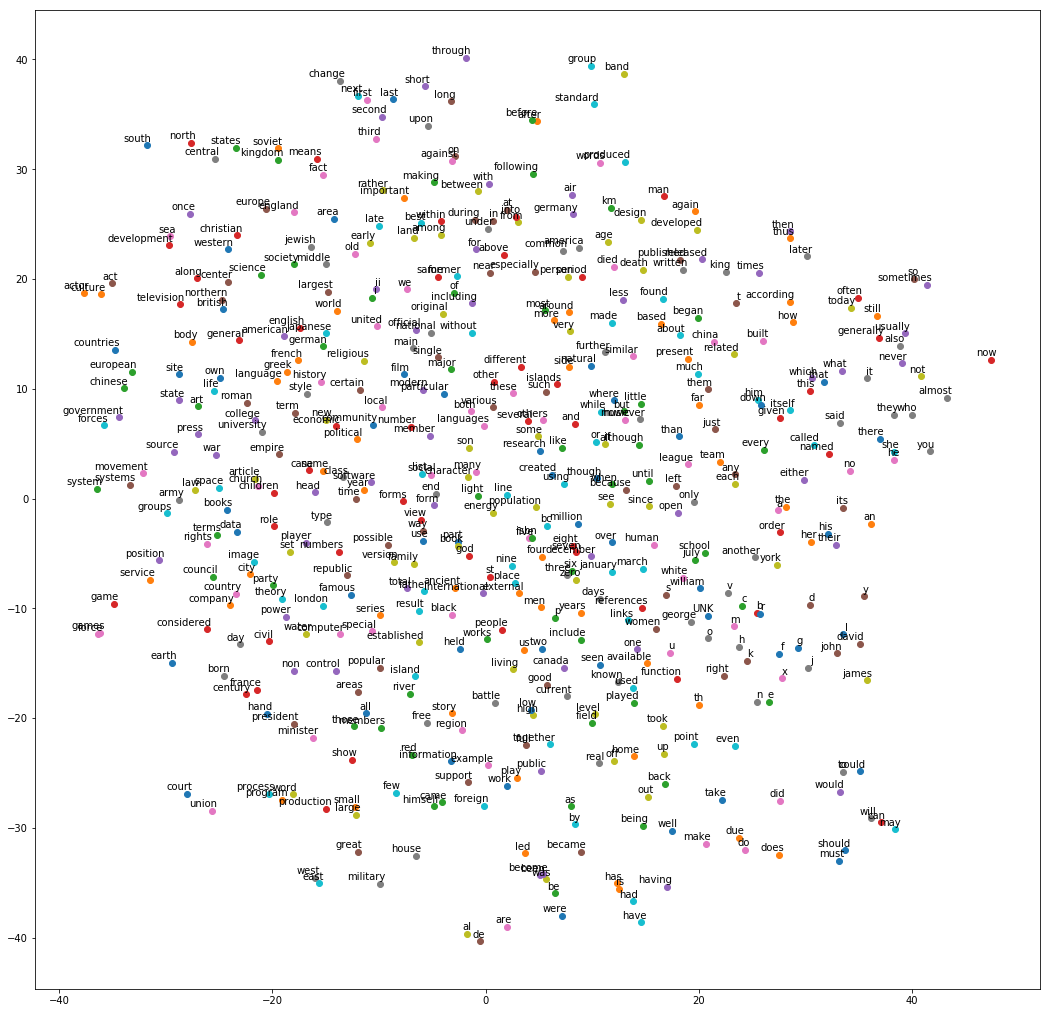

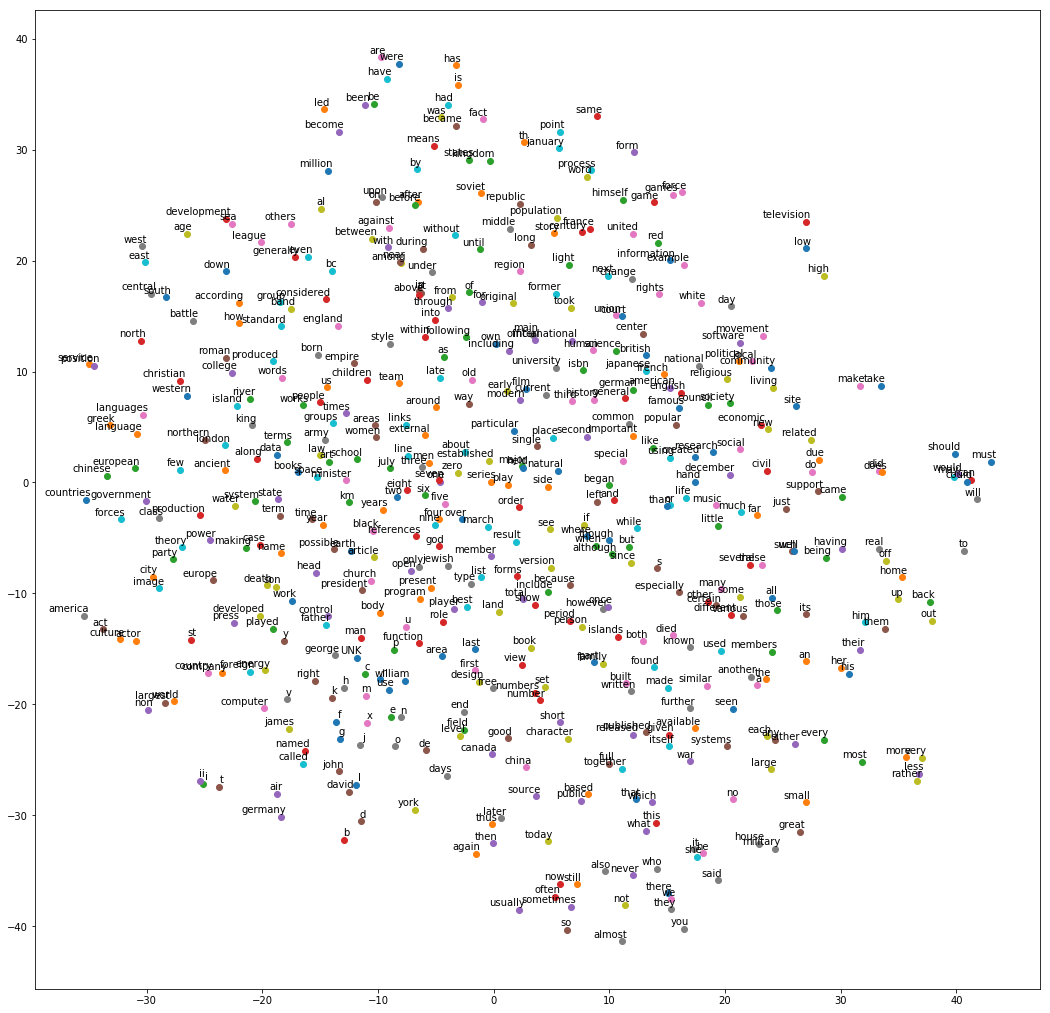

In [32]:
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.show()
  plt.savefig(filename)




tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reversed_dictionary[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))